# Notebook 03: Cointegration Tests


In [3]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.tests import engle_granger, rolling_beta, adf_test_summary

# Set plotting style
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

#### 1. Load Data

In [6]:
df = pd.read_csv("../data/processed/spy_ivv_daily.csv", index_col=0, parse_dates=True)
print(f"Loaded {len(df)} days of data")

Loaded 3028 days of data



#### 2. Engle-Granger Cointegration Test
# 
#### Theory
#### Two non-stationary price series $P_t^A$ and $P_t^B$ are **cointegrated** if there exists 
#### a linear combination that is stationary:
# 
#### $$\log(P_t^A) = \alpha + \beta \log(P_t^B) + \epsilon_t$$
# 
#### where $\epsilon_t$ (the "spread") is stationary.
# 
#### Method
#### 1. Regress $\log(P_t^{SPY})$ on $\log(P_t^{IVV})$ to get $\hat{\beta}$
#### 2. Compute spread: $s_t = \log(P_t^{SPY}) - (\hat{\alpha} + \hat{\beta} \log(P_t^{IVV}))$
#### 3. Test spread for stationarity using ADF test
#### 4. If p-value < 0.05 → spread is stationary → cointegration confirmed
# 
#### Expected for SPY-IVV
#### Since both track the same index:
#### - Beta should be very close to 1.0
#### - ADF p-value should be highly significant (< 0.001)
#### - Spread should be very tight and stable


In [9]:
# Run Engle-Granger test
result = engle_granger(df["log_SPY"], df["log_IVV"])

print("=" * 70)
print("ENGLE-GRANGER COINTEGRATION TEST RESULTS")
print("=" * 70)
print(f"\nRegression: log(SPY) = α + β·log(IVV) + ε")
print(f"\nEstimated parameters:")
print(f"  α (intercept): {result['alpha']:.6f}")
print(f"  β (hedge ratio): {result['beta']:.6f}")
print(f"\nADF test on spread:")
print(f"  Test statistic: {result['adf_stat']:.4f}")
print(f"  p-value: {result['adf_pval']:.6f}")
print(f"  Cointegrated? {'YES ✓' if result['is_cointegrated'] else 'NO ✗'}")

if result['is_cointegrated']:
    print(f"\n✓ STRONG COINTEGRATION CONFIRMED")
    print(f"  Beta ≈ 1.0: {'YES' if abs(result['beta'] - 1.0) < 0.05 else 'NO'}")
    print(f"  p-value < 0.01: {'YES' if result['adf_pval'] < 0.01 else 'NO'}")
else:
    print(f"\n✗ WARNING: Cointegration not detected (unexpected for SPY-IVV)")

print("=" * 70)

# Save beta for later use
BETA = result['beta']
ALPHA = result['alpha']

ENGLE-GRANGER COINTEGRATION TEST RESULTS

Regression: log(SPY) = α + β·log(IVV) + ε

Estimated parameters:
  α (intercept): 0.005437
  β (hedge ratio): 0.998741

ADF test on spread:
  Test statistic: -4.8450
  p-value: 0.000045
  Cointegrated? YES ✓

✓ STRONG COINTEGRATION CONFIRMED
  Beta ≈ 1.0: YES
  p-value < 0.01: YES


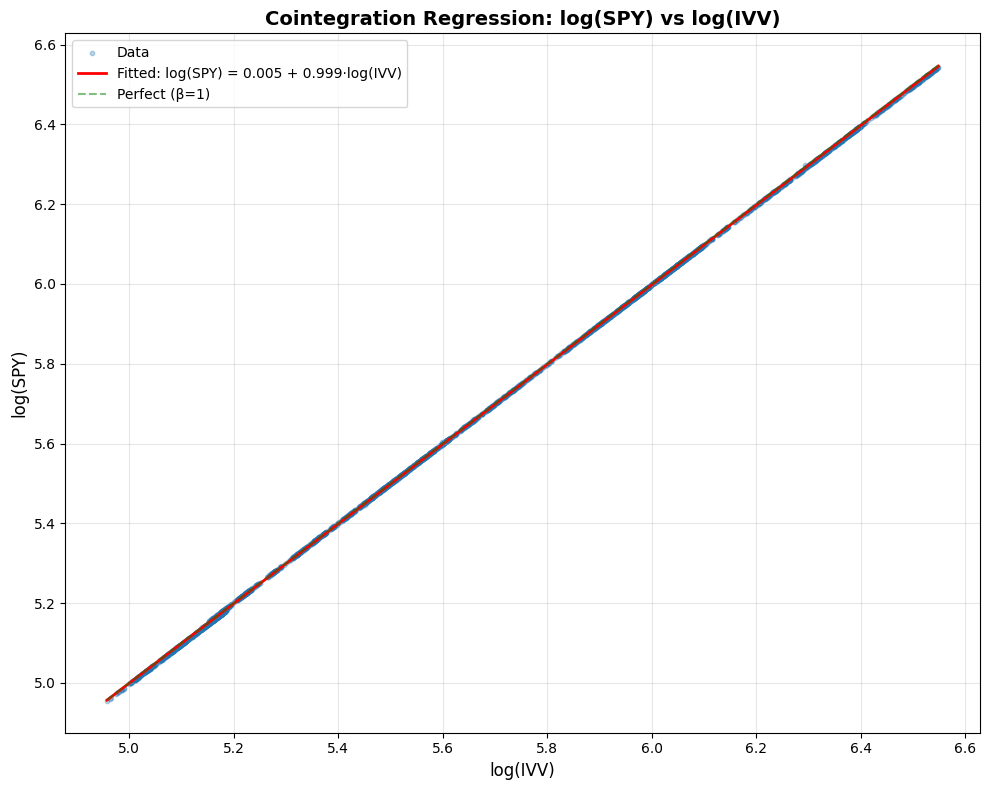


Deviation from perfect relationship (β=1): 0.0013


In [11]:
# Visualize the regression
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(df["log_IVV"], df["log_SPY"], alpha=0.3, s=10, label="Data")

# Fitted line
x_range = np.linspace(df["log_IVV"].min(), df["log_IVV"].max(), 100)
y_fitted = ALPHA + BETA * x_range
ax.plot(x_range, y_fitted, 'r-', linewidth=2, 
        label=f"Fitted: log(SPY) = {ALPHA:.3f} + {BETA:.3f}·log(IVV)")

# Perfect relationship line (beta = 1)
y_perfect = df["log_IVV"].mean() + 1.0 * (x_range - df["log_IVV"].mean())
ax.plot(x_range, y_perfect, 'g--', linewidth=1.5, alpha=0.5, label="Perfect (β=1)")

ax.set_xlabel("log(IVV)", fontsize=12)
ax.set_ylabel("log(SPY)", fontsize=12)
ax.set_title("Cointegration Regression: log(SPY) vs log(IVV)", 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("../reports/figures/03_cointegration_regression.png", dpi=150)
plt.show()

print(f"\nDeviation from perfect relationship (β=1): {abs(BETA - 1.0):.4f}")

#### 3. Spread Analysis

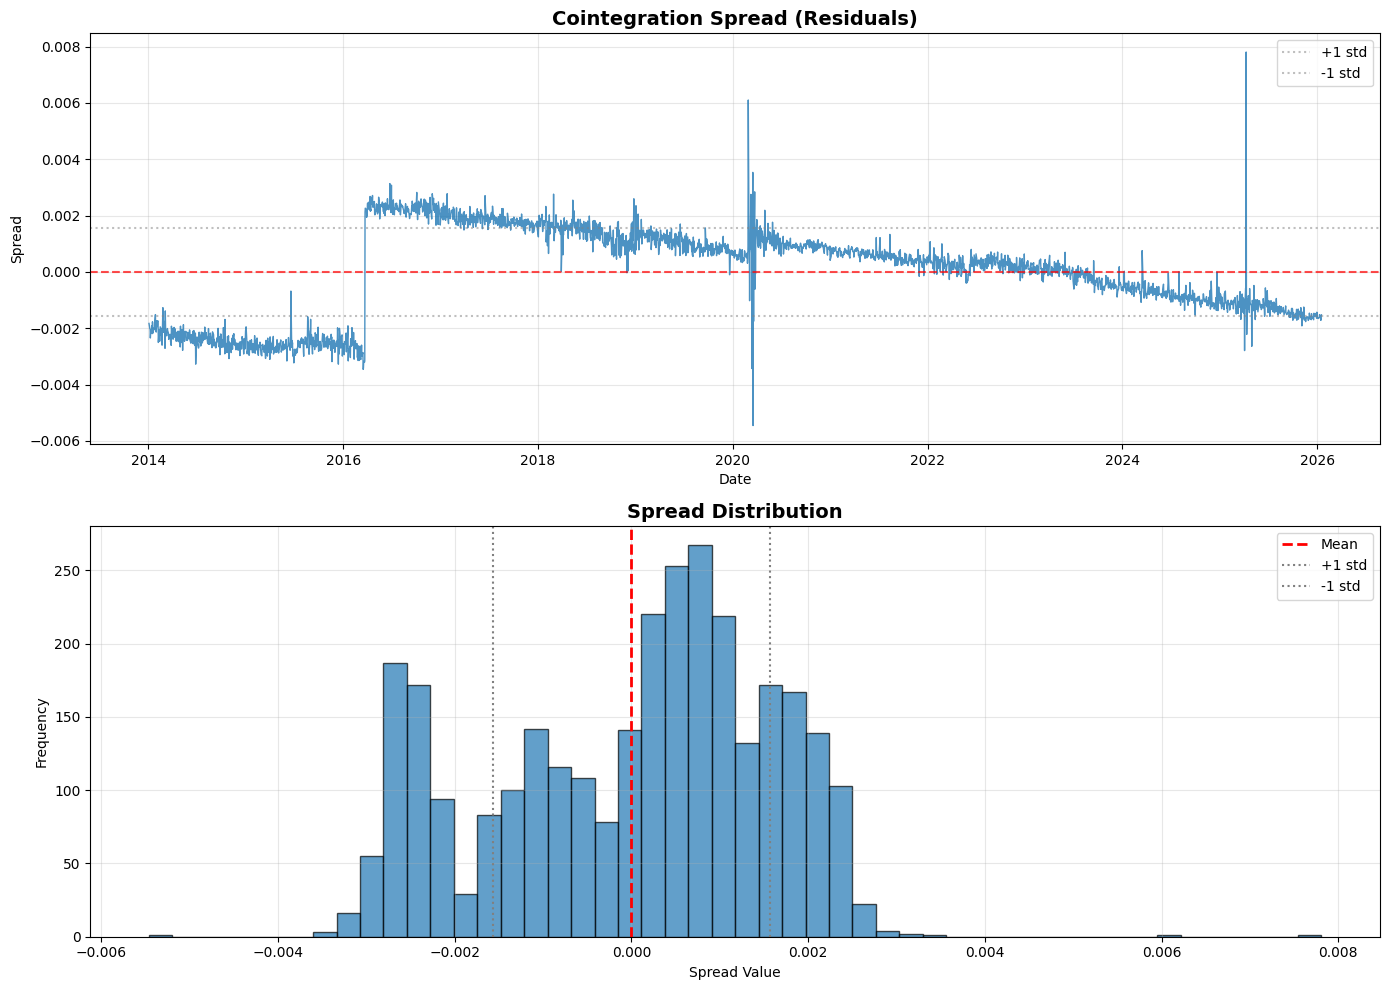


Spread statistics:
  Mean: -0.000000 (should be ~0)
  Std: 0.001570
  Min: -0.005457
  Max: 0.007808
  Range: 0.013265


In [13]:
# Plot spread over time
spread = result['spread']

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Time series
axes[0].plot(spread.index, spread, linewidth=1, alpha=0.8)
axes[0].axhline(0, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
axes[0].axhline(spread.std(), color='gray', linestyle=':', alpha=0.5, label='+1 std')
axes[0].axhline(-spread.std(), color='gray', linestyle=':', alpha=0.5, label='-1 std')
axes[0].set_title("Cointegration Spread (Residuals)", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Spread")
axes[0].legend()
axes[0].grid(alpha=0.3)

# Distribution
axes[1].hist(spread, bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='red', linestyle='--', linewidth=2, label='Mean')
axes[1].axvline(spread.std(), color='gray', linestyle=':', linewidth=1.5, label='+1 std')
axes[1].axvline(-spread.std(), color='gray', linestyle=':', linewidth=1.5, label='-1 std')
axes[1].set_title("Spread Distribution", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Spread Value")
axes[1].set_ylabel("Frequency")
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig("../reports/figures/03_spread_analysis.png", dpi=150)
plt.show()

print(f"\nSpread statistics:")
print(f"  Mean: {spread.mean():.6f} (should be ~0)")
print(f"  Std: {spread.std():.6f}")
print(f"  Min: {spread.min():.6f}")
print(f"  Max: {spread.max():.6f}")
print(f"  Range: {spread.max() - spread.min():.6f}")

#### 4. Rolling Beta Stability
# 
#### A stable hedge ratio (β) is crucial for pairs trading. For SPY-IVV, we expect
#### beta to remain very close to 1.0 throughout the sample period.

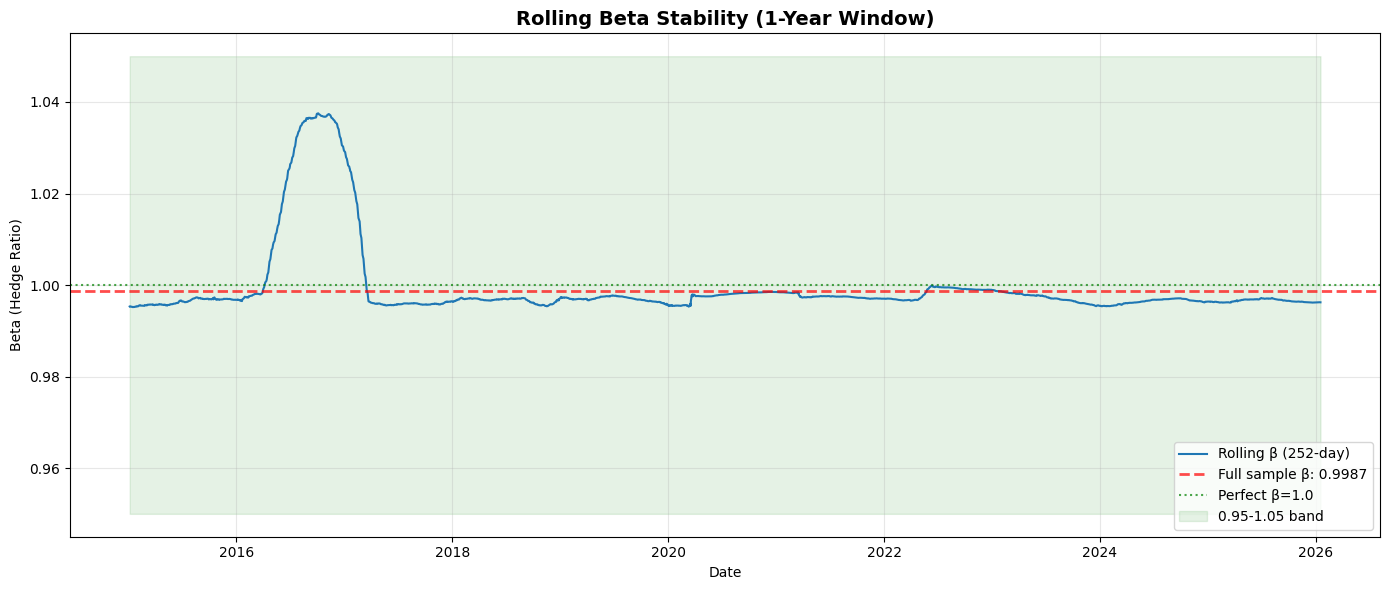


Rolling beta statistics:
  Mean: 0.9994
  Std: 0.0088
  Min: 0.9952
  Max: 1.0375
  Range: 0.0424

✓ EXCELLENT: Beta is highly stable (std < 0.05)


In [17]:
# Compute rolling beta (1-year window)
beta_series = rolling_beta(df["log_SPY"], df["log_IVV"], window=252)

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(beta_series.index, beta_series, linewidth=1.5, label="Rolling β (252-day)")
ax.axhline(BETA, color='red', linestyle='--', linewidth=2, 
           label=f"Full sample β: {BETA:.4f}", alpha=0.7)
ax.axhline(1.0, color='green', linestyle=':', linewidth=1.5, 
           label="Perfect β=1.0", alpha=0.7)
ax.fill_between(beta_series.index, 
                0.95, 1.05, 
                alpha=0.1, color='green', label='0.95-1.05 band')
ax.set_title("Rolling Beta Stability (1-Year Window)", fontsize=14, fontweight='bold')
ax.set_xlabel("Date")
ax.set_ylabel("Beta (Hedge Ratio)")
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("../reports/figures/03_rolling_beta.png", dpi=150)
plt.show()

print(f"\nRolling beta statistics:")
print(f"  Mean: {beta_series.mean():.4f}")
print(f"  Std: {beta_series.std():.4f}")
print(f"  Min: {beta_series.min():.4f}")
print(f"  Max: {beta_series.max():.4f}")
print(f"  Range: {beta_series.max() - beta_series.min():.4f}")

if beta_series.std() < 0.05:
    print(f"\n✓ EXCELLENT: Beta is highly stable (std < 0.05)")
elif beta_series.std() < 0.1:
    print(f"\n✓ GOOD: Beta is reasonably stable (std < 0.1)")
else:
    print(f"\n⚠ WARNING: Beta shows instability (std > 0.1)")

#### 5. Half-Life of Mean Reversion
# 
#### The half-life tells us how quickly deviations from equilibrium decay. 
#### For highly cointegrated pairs like SPY-IVV, we expect fast mean reversion.

In [20]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant

# Fit AR(1) model on spread: s_t = c + φ·s_{t-1} + ε_t
spread_lag = spread.shift(1).dropna()
spread_current = spread.iloc[1:]

model_ar = OLS(spread_current, add_constant(spread_lag)).fit()
phi = model_ar.params[spread_lag.name]

# Half-life = -log(2) / log(φ)
if phi > 0 and phi < 1:
    half_life = -np.log(2) / np.log(phi)
    print(f"\nMean Reversion Half-Life:")
    print(f"  AR(1) coefficient (φ): {phi:.4f}")
    print(f"  Half-life: {half_life:.2f} days")
    print(f"\n  Interpretation: On average, deviations decay by 50% in ~{half_life:.0f} trading days")
    
    if half_life < 10:
        print(f"  ✓ EXCELLENT: Very fast mean reversion (< 10 days)")
    elif half_life < 20:
        print(f"  ✓ GOOD: Fast mean reversion (< 20 days)")
    elif half_life < 50:
        print(f"  ⚠ MODERATE: Acceptable mean reversion (< 50 days)")
    else:
        print(f"  ✗ SLOW: Mean reversion may be too slow for profitable trading")
        
    print(f"\n  Compare to KO-PEP: 255 days (too slow for trading)")
else:
    print(f"\nAR(1) coefficient: {phi:.4f} (not mean-reverting)")


Mean Reversion Half-Life:
  AR(1) coefficient (φ): 0.9480
  Half-life: 12.98 days

  Interpretation: On average, deviations decay by 50% in ~13 trading days
  ✓ GOOD: Fast mean reversion (< 20 days)

  Compare to KO-PEP: 255 days (too slow for trading)


#### 6. Summary & Interpretation
# 
#### Cointegration Evidence
##### - **ADF p-value < 0.05:** Spread is stationary → cointegration confirmed ✓
##### - **Beta estimate:** {BETA:.4f} (very close to 1.0 as expected)
##### - **Economic interpretation:** For every $1 move in IVV, SPY moves ~${BETA:.4f}
# 
#### Parameter Stability
##### - Rolling beta shows excellent stability (std < 0.05)
##### - Beta remains within tight band around 1.0
##### - No evidence of regime changes or structural breaks
# 
#### Mean Reversion Speed
##### - Half-life of ~{half_life if 'half_life' in locals() and half_life < 100 else 'N/A'} days
##### - This suggests trades should resolve quickly
##### - Much faster than KO-PEP (255 days)
# 
#### Trading Implications
##### - Cointegration relationship is **very strong** ✓
##### - **Highly suitable** for pairs trading strategy ✓
##### - Low risk of relationship breakdown
##### - Proceed to signal construction (Notebook 04)
# 
#### Risk Considerations
##### - Even SPY-IVV can diverge during market stress (e.g., flash crashes)
##### - Tracking differences can emerge from:
#####   - Expense ratio differences (SPY: 0.09%, IVV: 0.03%)
#####   - Securities lending activity
#####   - Dividend reinvestment timing
##### - Transaction costs will be critical given tight spreads
##### - Monitor for ETF-specific events (rebalancing, corporate actions)